In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import astropy.units as u
import starry
from scipy import integrate
from astropy.io import fits
import pickle


starry.config.lazy = False
starry.config.quiet = True

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
/Users/andrew/opt/anaconda3/envs/starry_stable/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Spectral libraries used so far

All spectra are interpolated onto a uniform wavelength grid of 100 values between 0.4 and 2.5 microns.

dict_keys(['basalt', 'granite', 'sand', 'grass', 'trees', 'cloud', 'coast', 'snow', 'sea', 'bacterial_mat', 'cont_warm', 'cont', 'trees_nopig', 'cont_nopig', 'trees_nopig_dry', 'cont_noveg', 'PSB_avg', 'PSB_cont', 'hyd_wet', 'hyd_dry', 'hyd_cont_wet', 'hyd_cont_dry', 'hyd_ocean', 'hyd_cont_ocean'])


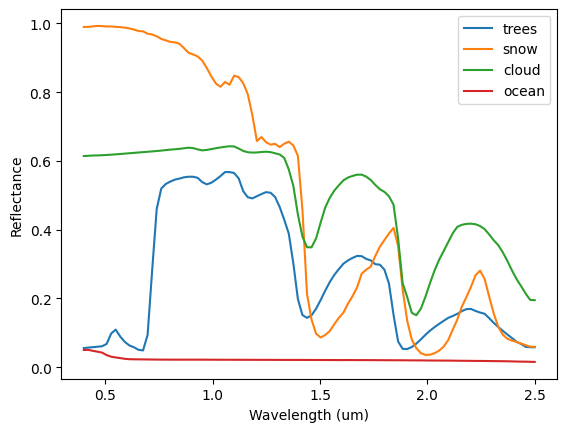

In [7]:
file = open('reflectance_spectra.pkl', 'rb')
spectra = pickle.load(file)
file.close()

print(spectra.keys())

plt.plot(spectra['trees'][:,0], spectra['trees'][:,1], label='trees')
plt.plot(spectra['snow'][:,0], spectra['snow'][:,1], label='snow')
plt.plot(spectra['cloud'][:,0], spectra['cloud'][:,1], label='cloud')
plt.plot(spectra['sea'][:,0], spectra['sea'][:,1], label='ocean')
plt.xlabel('Wavelength (um)')
plt.ylabel('Reflectance')
plt.legend()
plt.show()

### Functions to add clouds, coast, or polar regions to map

The value for "spec" in each function is really just a code for that region that will later be replaced with the albedo for the particular surface type.

In [25]:
def add_clouds(map, spec = 4., min_size = 30, max_size = 140, num = 6):

    ### This function takes a map and places random circular clouds over its surface. Call this function last, after coast. ###
    map_dims = map.shape
    cloud_pix = np.zeros((num, 3))

    for i in range(num):
        size = np.random.uniform(min_size, max_size)
        
        lon = np.random.uniform(0, map_dims[1])
        lat = np.random.uniform(0, map_dims[0])

        r_pix = int(size / map_dims[0] * map_dims[1])

        for x, y in np.ndindex(map.shape):
            if (x - lat)**2 + (y - lon)**2 < r_pix**2:
                map[x, y] = spec

        cloud_pix[i] = (lat, lon, r_pix)
    
    cum_coverage = (1. - np.count_nonzero(map - spec) / (map_dims[0] * map_dims[1])) * 100.

    print("{} percent cloud coverage".format(cum_coverage))
    plt.imshow(map)
    plt.colorbar()
    plt.show()

    return map, cum_coverage

def add_coast(map, spec = 2., size = 3.):
    coast_pix = 0

    coast_ij = np.zeros((map.shape[0], map.shape[1]))

    for row in range(len(map[:,0]) - 1):
        for col in range(len(map[0]) - 1):
            if map[row, col] != map[row, col+1]:
                coast_ij[row, col] = 1.
            if map[row, col] != map[row + 1, col]:
                coast_ij[row, col] = 0.8


    for row in range(len(coast_ij[:,0])):
        for col in range(len(coast_ij[0])):

            if coast_ij[row, col] == 1.:
                map[row, col] = spec
                for i in range(size):
                    if col + i < len(coast_ij[0]):
                        map[row, col+i] = spec
                        coast_pix += 1
                    if col - i > 0:
                        map[row, col-i] = spec
                        coast_pix += 1

            if coast_ij[row, col] == 0.8:
                map[row, col] = spec
                for i in range(size):
                    if row + i < len(coast_ij[:,0]):
                        map[row+i, col] = spec
                        coast_pix += 1
                    if row - i > 0:
                        map[row-i, col] = spec
                        coast_pix += 1

    percent_coast = (coast_pix / (map.shape[0] * map.shape[1])) * 100.
    print("This map is {} percent coast".format(percent_coast))
    
    return map, percent_coast

def add_poles(map, spec = 3., sea_north = 25, cont_north = 41, sea_south = 25, cont_south = 41):
    
    ### This function takes a map and places polar caps at the poles. Call this function after coast, but before clouds. ###
    ### North and south give pixel rows to assign as polar regions from top and bottom of map. ###  

    map[:sea_north] = spec
    map[-sea_south:] = spec
    map[sea_north:cont_north][map[sea_north:cont_north] == 1.] = spec
    map[-cont_south:-sea_south][map[-cont_south:-sea_south] == 1.] = spec

    cum_coverage = (1. - np.count_nonzero(map - spec) / (map.shape[0] * map.shape[1])) * 100.

    print("{} percent polar coverage".format(cum_coverage))
    plt.imshow(map)
    plt.colorbar()
    plt.show()

    return map, cum_coverage

### Function to create a spectral map using assigned spectra

In [30]:
def make_spectral_map(
        map,
        wav, 
        cont_id, 
        cont_spec, 
        ocean_id, 
        ocean_spec, 
        cloud_id = None,
        cloud_spec = None,
        snow_id = None,
        snow_spec = None,
        coast_id = None,
        coast_spec = None,
        ydeg = 20,
        scalar_index = 57
    ):
    
    ### This function takes a map and assigns spectral values to different regions.                     ###
    ### The ID values are the code for that region in the map.                                          ###
    ### The spec values are the spectral reflectance of that region, and should be same length as wav.  ###
    ### Function assumes map has at least continents and oceans.                                        ###

    map_refl_spec = np.ones((len(wav), 320, 640))
    specmap_y = np.zeros((len(wav), (ydeg+1)**2))
    specmap_y_shift = np.zeros((len(wav), (ydeg+1)**2))
    specmap_p = np.zeros((len(wav), 996))
    minpix = np.zeros((len(wav)))
    maxpix = np.zeros((len(wav)))
    amps = np.zeros((len(wav)))

    specmap = starry.Map(ydeg = ydeg, reflected=True)
    scalarmap = starry.Map(ydeg = ydeg, reflected=True)

    if cloud_id is None:
        cloud_spec = np.nan * np.ones(len(wav))
    if snow_id is None:
        snow_spec = np.nan * np.ones(len(wav))
    if coast_id is None:
        coast_spec = np.nan * np.ones(len(wav))

    for wl in range(len(wav)):
    
        specmap.reset()
        image = map.copy()

        image[image == cont_id] = cont_spec[wl]
        image[image == ocean_id] = ocean_spec[wl]
        if cloud_id is not None:
            image[image == cloud_id] = cloud_spec[wl]
        if snow_id is not None:
            image[image == snow_id] = snow_spec[wl]
        if coast_id is not None:
            image[image == coast_id] = coast_spec[wl]

        map_refl_spec[wl] = image

        specmap.load(image, smoothing = 0.1)
        specmap_y[wl] = specmap.y

        _, _, Y2P, P2Y, _, _ = specmap.get_pixel_transforms()
        p = Y2P.dot(specmap.y)

        #Pixel stretch to match max/min albedo to max/min pixel value
        maxi = np.nanmax((cont_spec[wl], ocean_spec[wl], cloud_spec[wl], snow_spec[wl], coast_spec[wl]))
        mini = np.nanmin((cont_spec[wl], ocean_spec[wl], cloud_spec[wl], snow_spec[wl], coast_spec[wl]))

        p = p / np.max(p) * (maxi - mini) + np.min(p)

        #Pixel shift to set min val 
        
        #shift = np.min(p) - 0.1         # shift the pixel values so that the minimum is 0.1
        shift = np.min(p) - mini      # shift the pixel values so that the minimum is ocean reflectance
        p = p - shift

        specmap_p[wl] = p

        y = P2Y.dot(p)

        specmap_y_shift[wl] = y

        minpix[wl] = np.min(p)
        maxpix[wl] = np.max(p)  
        
        amps[wl] = y[0] * 0.5

        if wl == scalar_index:
            print(np.max(image))
            plt.imshow(image)
            plt.colorbar()
            plt.show()
            scalarmap.load(image, smoothing = 0.1)
        
    fullspecmap = starry.Map(ydeg=ydeg, reflected=True, nw = len(wav), wav = wav)

    for wl in range(len(wav)):
        fullspecmap[1:, :, wl] = specmap_y_shift[wl][1:]/specmap_y_shift[wl][0]
        fullspecmap.amp[wl] = specmap_y_shift[wl][0]
    
    ### Function returns:
    ### fullspecmap: a multiwavelength starry map with the spectral reflectance encoded  - feed this into the simulated observation
    ### scalarmap: a starry map with the reflectance values of the map at the scalar_index wavelength - for visualisation purposes
    ### map_refl_spec: the image of the map for each wavelength
    ### specmap_y: the spherical harmonic coefficients for each wavelength before pixel stretching
    ### specmap_y_shift: the spherical harmonic coefficients for each wavelength after pixel stretching
    ### specmap_p: the pixel values for each wavelength
    ### minpix: the minimum pixel value for each wavelength
    ### maxpix: the maximum pixel value for each wavelength
    ### amps: the amplitude of the y0 coefficient for each wavelength
  
    return fullspecmap, scalarmap, map_refl_spec, specmap_y, specmap_y_shift, specmap_p, minpix, maxpix, amps

### Function to simulate an observation

In [33]:
def refl_spec_obs(
        map,
        scalarmap, 
        num_obs = 30, 
        num_nights = 1,
        texp = 30.,             #Observational units assumed to be in minutes (texp, cadence)
        cadence = 60.,          
        phase_init = 90., 
        theta_init = 0., 
        snr = 30., 
        comp_time = 1.,         #Cadence of starry flux computations to be integrated    
        a = 150E6,              #Orbit/planet scales in units of km (a, R)
        Rp = 6400.,
        Rstar = 700000., 
        prot = 1., 
        porb = 365.25,          #Orbital and rotational periods in units of days (prot, porb)
        obl = 23.5,
        dist = 5.,              #Distance to system in parsecs
        plot = True
    ):

    if cadence < texp:
        print('Warning! Cadence is less than exposure time. Correct if you want meaningful results.')
    
    ###########################################################
    # Compute the observation times and number of evaluations #
    ###########################################################    
    obs_per_night = np.zeros(num_nights)
    for night in range(num_nights):
        obs_per_night[night] = round(num_obs / num_nights)
        #print(obs_per_night[night])
        if obs_per_night[night] * cadence > (12 * 60.):
            print('Warning! Observation time per night is greater than 12 hours. Conisder breaking into multiple nights for ground based observations.')
         
    # obs_per_night[-1] = num_obs - np.sum(obs_per_night[:-1])
    # if obs_per_night[-1] * cadence > (12 * 60.):
    #     print('Warning! Observation time per night is greater than 12 hours. Conisder breaking into multiple nights for ground based observations.')

    obs_time = (num_nights - 1) * 24. * 60. + obs_per_night[-1] * cadence

    num_eval = int(obs_time/comp_time)

    t_obs = np.zeros((num_nights, int(obs_per_night[0])))
    for night in range(num_nights):
        t_obs[night] = np.arange(night * 24. * 60., night * 24. * 60. + obs_per_night[night] * cadence, cadence)
    
    #########################################################
    # Compute planet's orbital position at each observation #
    #########################################################
    
    phase_final = phase_init + obs_time / (porb * 24 * 60.) * 360.
    obs_phase = np.linspace(phase_init, phase_final, num_eval)

    r = a/Rp # Planet - star distance in units of Earth radii
    #Phase = 0 is secondary eclipse, phase = 180 is transit
    x = r * np.sin(np.deg2rad(obs_phase))
    z = r * np.cos(np.deg2rad(obs_phase))
    y = np.zeros_like(x)

    ang_sep = x * Rp/(dist * 30856775814671.914)


    ################################################################
    # Compute the rotation angle of the planet at each observation #
    ################################################################

    theta_final = theta_init + obs_time / (prot * 24 * 60.) * 360.
    theta = np.linspace(theta_init, theta_final, num_eval)

    #Compute the flux throughout the observation
    map.obl = obl
    flux = map.flux(theta = theta, xs = x, ys = y, zs = z, rs = Rstar/Rp)


    #############################################################
    # Integrate over the exposure time to get the observed flux #
    #############################################################
    int_flux = np.zeros((num_nights, int(obs_per_night[0]), len(map.wav)))
    
    if num_nights == 1:
        obs_params = {
            'x': np.zeros(2), 
            'z': np.zeros(2), 
            'theta': np.zeros(2),
            'ang_sep': np.zeros(2),
            'obs_phase': np.zeros(2)
            }
        start = int(t_obs[0] / comp_time)
        end = start + int(texp / comp_time) - 1
        int_flux[0] = integrate.simpson(flux[start:end], dx = comp_time, axis = 0)

        obs_params['x'][0] = x[start]
        obs_params['z'][0] = z[start]
        obs_params['theta'][0] = theta[start]
        obs_params['ang_sep'][0] = ang_sep[start]
        obs_params['obs_phase'][0] = obs_phase[start]

        obs_params['x'][1] = x[end]
        obs_params['z'][1] = z[end]
        obs_params['theta'][1] = theta[end]
        obs_params['ang_sep'][1] = ang_sep[end]
        obs_params['obs_phase'][1] = obs_phase[end]
    else:
        for night in range(num_nights):
            obs_params = {
                'x': np.zeros((num_nights, int(obs_per_night[0]))), 
                'z': np.zeros((num_nights, int(obs_per_night[0]))), 
                'theta': np.zeros((num_nights, int(obs_per_night[0]))),
                'ang_sep': np.zeros((num_nights, int(obs_per_night[0]))),
                'obs_phase': np.zeros((num_nights, int(obs_per_night[0])))
                }
            for i in range(len(t_obs[night])):
                start = int(t_obs[night][i] / comp_time)
                #print(start)
                end = start + int(texp / comp_time)
                #print(end)
                int_flux[night][i] = integrate.simpson(flux[start:end], dx = comp_time, axis = 0)

                obs_params['x'][night][i] = x[start]
                obs_params['z'][night][i] = z[start]
                obs_params['theta'][night][i] = theta[start]
                obs_params['ang_sep'][night][i] = ang_sep[start]
                obs_params['obs_phase'][night][i] = obs_phase[start]


    #########################
    # Add noise to the flux #
    #########################

    wav = map.wav
    signal = np.max(int_flux) - np.min(int_flux)
    scale = signal / snr
    print(scale)
    noise = np.random.normal(0, scale, size = (num_nights, int(obs_per_night[0]), len(wav)))
    int_flux_noise = int_flux + noise

    R = .700 / ((wav[-1] - wav[0])/len(wav)) # Resolution

    print("This observation lasts for {} days at R = {} (at 700 nm)."
        .format(
            np.round(obs_time/(60*24), decimals=2), 
            np.round(R, decimals = 2)
            ))
    
    print("The planet moves from phase angle between {} and {} degrees and at a rotation angle between {} and {} degrees."
          .format(
            obs_phase[0], 
            np.round(obs_phase[-1], decimals=1), 
            theta[0], 
            np.round(theta[-1]%360., decimals=1)
    ))

    print("The planet completes {} rotations and {} orbits."
          .format(
            np.round((theta[-1] - theta[0])/360., decimals=2),
            np.round((obs_phase[-1] - obs_phase[0])/360., decimals=2)
          ))
    
    ##########################
    # Plot the observed flux #
    ##########################
    # mpl.rcParams.update(mpl.rcParamsDefault)
    # plt.rcParams['text.usetex'] = False
    elt_angles = (2*700E-9/38.5, 3*700E-9/38.5)
    elt_labels = ('2lambda/D', '3lambda/D')

    if plot == True:
        # Create a figure and axes
        if num_nights == 1:
            fig, axs = plt.subplots(5, 1, figsize=(10, 37.5))

            ax = axs[0]
            ax.plot(map.wav, int_flux[0][0])
            ax.set_xlabel('Wavelength (micron)')
            ax.set_ylabel('Flux')
            ax.set_title('Simulated Reflection Spectrum (No Noise)')

            ax = axs[1]
            ax.errorbar(map.wav, int_flux_noise[0][0], yerr = scale, fmt = 'o')
            ax.plot(map.wav, int_flux[0][0], color = 'black', alpha = 0.5)
            ax.set_xlabel('Wavelength (micron)')
            ax.set_ylabel('Flux')
            ax.set_title('Simulated Reflection Spectrum (With Noise)')

            ax = axs[2]
            scalarmap.show(
                theta = obs_params['theta'][0], 
                xs = obs_params['x'][0], 
                ys = np.zeros_like(obs_params['x'][0]), 
                zs = obs_params['z'][0], 
                ax = ax)
            
            ax = axs[3]
            scalarmap.show(
                theta = obs_params['theta'][-1], 
                xs = obs_params['x'][-1], 
                ys = np.zeros_like(obs_params['x'][-1]), 
                zs = obs_params['z'][-1], 
                ax = ax)
            
            ax = axs[4]
            ax.plot(np.linspace(0, texp, 20), np.linspace(obs_params['ang_sep'][0], obs_params['ang_sep'][-1], 20))
            ax.hlines(elt_angles[0], 0, texp, color = 'red', linestyle = '--', label = elt_labels[0])
            ax.hlines(elt_angles[1], 0, texp, color = 'blue', linestyle = '--', label = elt_labels[1])
            ax.set_xlabel('Obs Time (Night {})'.format(night + 1))
            ax.set_ylabel('Angular Separation')
            ax.legend()

            axs[0].set_title('Simulated Reflection Spectrum (No Noise)')
            axs[1].set_title('Simulated Reflection Spectrum (With Noise)')
            axs[2].set_title('Illumination of Planet - Start of night')
            axs[3].set_title('Illumination of Planet - End of night')
            axs[4].set_title('Angular Separation')


            plt.show()

        else:
            fig, axs = plt.subplots(num_nights, 5, figsize=(37.5,5 * num_nights))
            cmap = plt.get_cmap('viridis')

            for night in range(num_nights):
                # Get the current axis
                ax = axs[night][0]
                # Create a color mapping
                norm = plt.Normalize(vmin=np.min(int_flux[night]*1E9), vmax=np.max(int_flux[night]*1E9))
                # Plot the flux as an image with color mapping
                im = ax.imshow(int_flux[night]*1E9, cmap=cmap, norm=norm, aspect='auto', origin = 'lower',
                                extent=(wav[0], wav[-1], t_obs[night][0] - night * 24 * 60., t_obs[night][-1] - night * 24 * 60.))
                # Add a color bar to show the mapping
                cbar = ax.figure.colorbar(im, ax=ax)
                # Add labels and titles
                ax.set_ylabel('Obs Time (Night {})'.format(night + 1))
                cbar.ax.set_ylabel('Flux (ppb)')
                ax.set_xlabel('Wavelength (micron)')

                ax = axs[night][1]
                norm = plt.Normalize(vmin=np.min(int_flux_noise[night]*1E9), vmax=np.max(int_flux_noise[night]*1E9))
                im = ax.imshow(int_flux_noise[night]*1E9, cmap=cmap, norm=norm, aspect='auto', origin = 'lower',
                                extent=(wav[0], wav[-1], t_obs[night][0] - night * 24 * 60., t_obs[night][-1] - night * 24 * 60.))
                cbar = ax.figure.colorbar(im, ax=ax)
                
                ax.set_xlabel('Wavelength (micron)')
                ax.set_ylabel('Obs Time (Night {})'.format(night + 1))
                cbar.ax.set_ylabel('Flux (ppb)')

                ax = axs[night][2]
                scalarmap.show(
                    theta = obs_params['theta'][night][0], 
                    xs = obs_params['x'][night][0], 
                    ys = np.zeros_like(obs_params['x'][night][0]), 
                    zs = obs_params['z'][night][0], 
                    ax = ax)
                
                ax = axs[night][3]
                scalarmap.show(
                    theta = obs_params['theta'][night][-1], 
                    xs = obs_params['x'][night][-1], 
                    ys = np.zeros_like(obs_params['x'][night][-1]), 
                    zs = obs_params['z'][night][-1], 
                    ax = ax)
                
                ax = axs[night][4]
                ax.plot(t_obs[night], obs_params['ang_sep'][night])
                ax.hlines(elt_angles[0], t_obs[night][0], t_obs[night][-1], color = 'red', linestyle = '--', label = elt_labels[0])
                ax.hlines(elt_angles[1], t_obs[night][0], t_obs[night][-1], color = 'blue', linestyle = '--', label = elt_labels[1])
                ax.set_xlabel('Obs Time (Night {})'.format(night + 1))
                ax.set_ylabel('Angular Separation')
                ax.legend()
                ax_b = ax.twinx()
                ax_b.plot(t_obs[night], obs_params['obs_phase'][night], color = 'green')
                ax_b.set_ylabel('Phase Angle')

            axs[0][0].set_title('Simulated Reflection Spectrum (No Noise)')
            axs[0][1].set_title('Simulated Reflection Spectrum (With Noise)')
            axs[0][2].set_title('Illumination of Planet - Start of night')
            axs[0][3].set_title('Illumination of Planet - End of night')
            axs[0][4].set_title('Angular Separation')

            plt.show()

    ### Function returns:
    ### int_flux: the observed flux without noise
    ### int_flux_noise: the observed flux with noise
    ### flux: the flux throughout the observation prior to integration - the pure signal generated from the model
    ### obs_phase: the phase of the planet at each observation
    ### theta: the rotation angle of the planet at each observation
    ### obs_time: the total observation time
    ### t_obs: the time of each observation

    return int_flux, int_flux_noise, flux, obs_phase, theta, obs_time, t_obs

### To import an image as a map

(320, 640)
204800
320
640


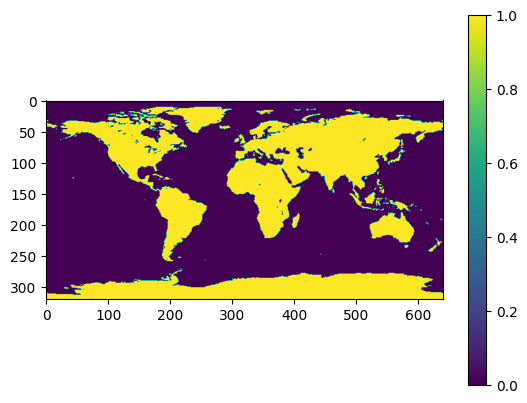

This map is 23.306640625 percent coast
19.070800781249996 percent polar coverage


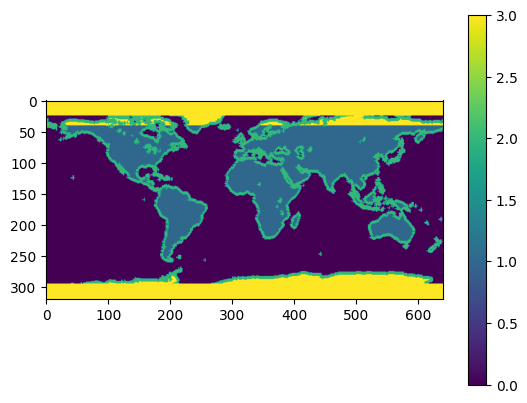

39.0986328125 percent cloud coverage


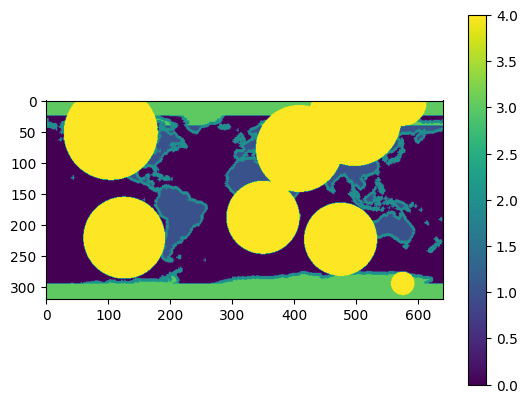

In [36]:
image0 = plt.imread('/Users/andrew/opt/anaconda3/envs/starry_stable/earth.png')

# Assigning continent values to 1, ocean values to 0 
image0[image0 < 0.5] = 0.
image0[image0 >= 0.5] = 1.

plt.imshow(image0)
plt.colorbar()
plt.show()

image0, _ = add_coast(image0, 2., size = 3)

image0, _ = add_poles(image0, 3., sea_north = 25, cont_north = 41, sea_south = 25, cont_south = 41)

image0, _ = add_clouds(image0, 4., num = 10)

### Calling the function to create the full spectral map

0.5434498


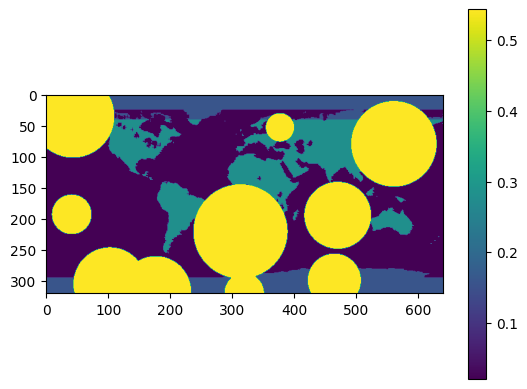

In [31]:
fullspecmap, scalarmap, _, _, _, _, _, _, _ = make_spectral_map(
        image0,
        spectra['sea'][:,0], 
        1., 
        spectra['cont_warm'][:,1], 
        0., 
        spectra['sea'][:,1], 
        cloud_id = 4.,
        cloud_spec = spectra['cloud'][:,1],
        snow_id = 3.,
        snow_spec = spectra['snow'][:,1],
        coast_id = 2.,
        coast_spec = spectra['coast'][:,1],
        ydeg = 20,
        scalar_index = 57
 )

### Simulating an observation using values for Proxima Centauri 

2.6247838941235015e-05
This observation lasts for 0.33 days at R = 33.33 (at 700 nm).
The planet moves from phase angle between 20.0 and 30.7 degrees and at a rotation angle between 360.0 and 10.7 degrees.
The planet completes 0.03 rotations and 0.03 orbits.


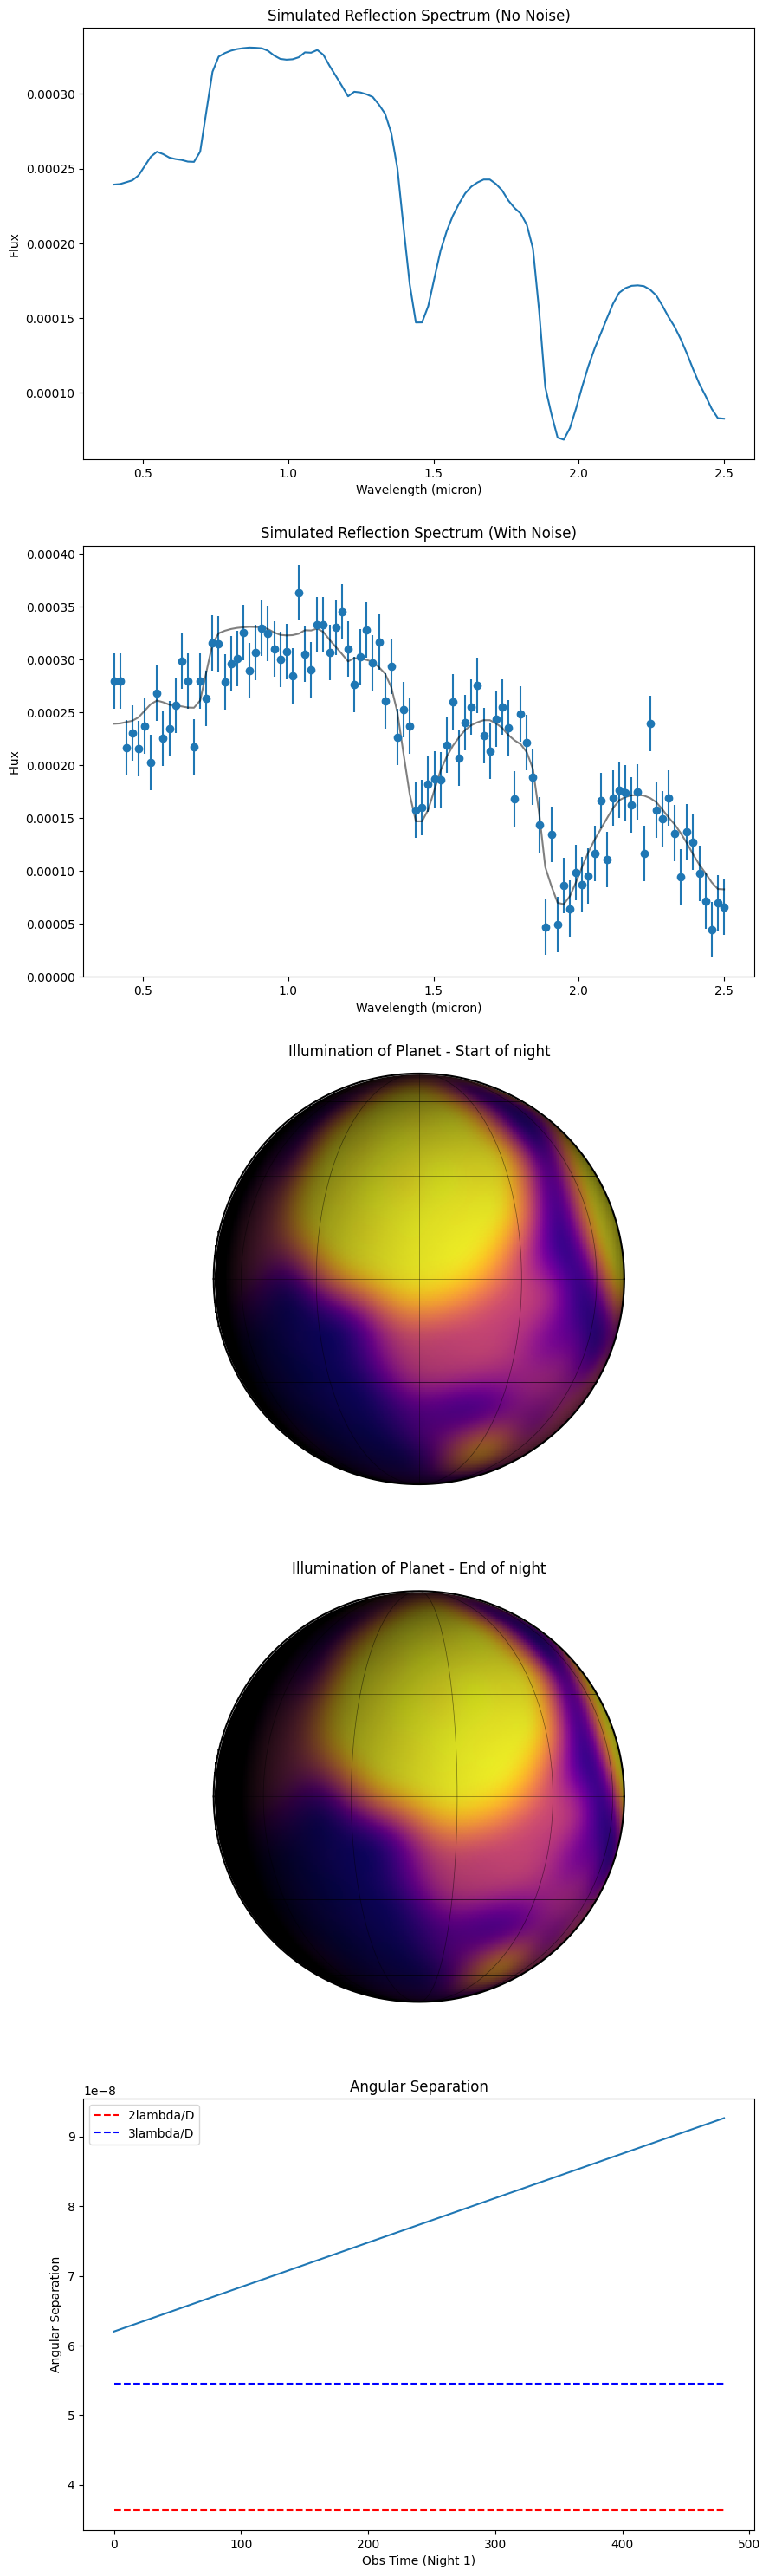

In [37]:
R_prox_cent_b = 1.07 * 6371.
a_prox_cent_b = 0.04856 * 150E6
P_prox_cent_b = 11.1868
dist_prox_cent_b = 1.30197
R_prox_star = 0.141 * 695508

theta_range = np.linspace(0, 360, 6)

int_flux, int_flux_noise, flux, obs_phase, theta, obs_time, t_obs = refl_spec_obs(
    fullspecmap,
    scalarmap, 
    num_obs = 1, 
    num_nights = 1, 
    cadence = 8 * 60., 
    texp = 8 * 60., 
    phase_init = 20., 
    theta_init = 360., 
    snr = 10.,
    Rp = R_prox_cent_b,
    a = a_prox_cent_b,
    porb = P_prox_cent_b,
    prot = P_prox_cent_b,
    dist = dist_prox_cent_b
    )
